In [1]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)

✅ Style+Font ready: NanumGothic


# DAY 9 — Seasonal Limitation of Solar PV on Evening Load

## 1. Analysis Question
태양광 발전은 계절에 따라 Evening Load를 얼마나 커버하지 못하는가?

## 2. Analysis Perspective
- Evening Load를 구조적 부담 구간으로 정의
- 본 분석은 전력 수요가 아닌 **태양광의 시간대·계절적 한계**에 초점

## 3. Data & Scope
- 대상 시간대: Evening Load (18–21시)
- 계절 구분: Summer / Winter
- 비교 관점:
  - Evening Load 자체의 변화
  - 태양광 가용 시간의 계절적 차이 (이론적 관점)

## 4. Method
- Evening Load 시간대 필터링
- 계절별 Evening 평균 부하 비교
- 태양광 이론적 발전 시간과의 구조적 관계 해석

## 5. Result
- Evening Load는 계절과 무관하게 반복적으로 나타남
- 반면 태양광 가용 시간은 계절에 따라 크게 달라짐

## 6. Interpretation
- 태양광은 Daytime 부하에는 기여 가능
- Evening Load는 태양광 발전 시간대와 구조적으로 불일치
- 이 불일치는 겨울철에 더욱 확대됨

## 7. Key Takeaway
태양광은 Evening Load에 대한 직접적 대응 수단이 아니며,
계절성은 이러한 한계를 더욱 분명하게 만든다.

In [ ]:
# -------------------------
# 0) Load CSV (auto-find project root by /data)
# -------------------------
cwd = Path.cwd()
PROJECT_ROOT = None
for p in [cwd, *cwd.parents]:
    if (p / "data").exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError("data 폴더를 찾지 못했습니다. notebooks 폴더에서 실행하거나 경로를 확인하세요.")

DATA_DIR = PROJECT_ROOT / "data"
LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"

df_raw = pd.read_csv(LOAD_FILE)

print("Loaded:", LOAD_FILE.name)
print("Columns:", df_raw.columns.tolist())

# -------------------------
# 1) Build datetime (robust)
# -------------------------
if "datetime" in df_raw.columns:
    df_raw["datetime"] = pd.to_datetime(df_raw["datetime"], errors="coerce")

else:
    # 후보 컬럼 자동 탐지
    date_candidates = [c for c in df_raw.columns if c.upper() in ["USE_YM", "USE_DT", "USE_YMD", "DATE", "DT", "YMD"]]
    time_candidates = [c for c in df_raw.columns if c.upper() in ["USE_HM", "TIME", "HM", "HOUR", "HH"]]

    if not date_candidates or not time_candidates:
        raise KeyError(
            "datetime 생성용 날짜/시간 컬럼을 못 찾았어.\n"
            f"- date 후보: {date_candidates}\n"
            f"- time 후보: {time_candidates}\n"
            f"현재 컬럼: {df_raw.columns.tolist()}"
        )

    date_col = date_candidates[0]
    time_col = time_candidates[0]

    # 숫자만 추출
    date_str = df_raw[date_col].astype(str).str.replace(r"\D", "", regex=True)
    time_str = df_raw[time_col].astype(str).str.replace(r"\D", "", regex=True)

    # date는 YYYYMMDD(8) 또는 YYYYMM(6) 가정
    mode_len = int(date_str.str.len().mode().iloc[0])
    if mode_len == 6:
        # YYYYMM -> YYYYMM01
        date_str = date_str + "01"
    elif mode_len == 8:
        pass
    else:
        # 방어: 길이가 섞여 있으면 6/8 둘 다 처리 시도
        date_str = np.where(date_str.str.len() == 6, date_str + "01", date_str)
        date_str = pd.Series(date_str)

    # time은 HHMM로 맞추기 (예: 1 -> 0001이 아니라 '01:00'일 수도 있으니 규칙을 분기)
    # 케이스 A) 값이 100, 200, ..., 2300, 2400 형태 (HHMM)
    # 케이스 B) 값이 1~24 형태 (hour)
    # -> 숫자 범위를 보고 분기
    time_num = pd.to_numeric(time_str, errors="coerce")

    # 기본 hour/minute 추출
    # HHMM 형태 가능성이 높으면 (>=100 이거나 0 포함) HHMM로 해석
    is_hhmm = (time_num.dropna() >= 100).mean() > 0.5

    if is_hhmm:
        hh = (time_num // 100).astype("Int64")
        mm = (time_num % 100).astype("Int64")
    else:
        # hour 형태(1~24 or 0~23)로 해석, 분은 0
        hh = time_num.astype("Int64")
        mm = pd.Series([0] * len(df_raw), index=df_raw.index).astype("Int64")

    # 2400(=24:00) 처리: 00:00로 바꾸고 다음날 +1일
    add_day = (hh == 24) & (mm == 0)
    hh = hh.where(~add_day, 0)

    # date 파싱
    date_dt = pd.to_datetime(date_str, format="%Y%m%d", errors="coerce")

    # datetime 생성 (분 단위까지)
    dt = date_dt + pd.to_timedelta(hh.fillna(0), unit="h") + pd.to_timedelta(mm.fillna(0), unit="m")
    dt = dt + pd.to_timedelta(add_day.fillna(False).astype(int), unit="D")

    df_raw["datetime"] = dt

# -------------------------
# 2) Clean + Base cols
# -------------------------
df = df_raw.dropna(subset=["datetime"]).copy()
df["hour"] = df["datetime"].dt.hour
df["month"] = df["datetime"].dt.month

# -------------------------
# 3) Standardize load column -> value
# -------------------------
if "value" not in df.columns:
    if "FDRCT_VLD_KWH" in df.columns:
        df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"], errors="coerce")
    else:
        raise KeyError("부하 컬럼을 못 찾았어. 'value' 또는 'FDRCT_VLD_KWH' 필요.")

df = df.dropna(subset=["value"]).copy()

print("Rows:", len(df))
print("Datetime range:", df["datetime"].min(), "~", df["datetime"].max())
print("Hour range:", df["hour"].min(), "~", df["hour"].max())
print("Month range:", df["month"].min(), "~", df["month"].max())

df[["datetime", "hour", "month", "value"]].head(3)

Loaded: 법정동별시간별전력사용량.csv
Columns: ['SIGUNGU_CD', 'BJDONG_CD', 'USE_YM', 'USE_HM', 'FDRCT_VLD_KWH']
Rows: 9754804
Datetime range: 2022-06-28 01:00:00 ~ 2024-01-29 00:00:00
Hour range: 0 ~ 23
Month range: 1 ~ 12


,datetime,hour,month,value
0,2022-06-28 01:00:00,1,6,10782.0565
1,2022-06-28 01:00:00,1,6,11394.8635
2,2022-06-28 01:00:00,1,6,7273.9620


In [3]:
# 4계절 추가
df9 = df.copy()
df9["month"] = df9["datetime"].dt.month

def season_4(m):
    if m in [3,4,5]:
        return "Spring"
    elif m in [6,7,8]:
        return "Summer"
    elif m in [9,10,11]:
        return "Fall"
    else:  # 12,1,2
        return "Winter"

df9["season"] = df9["month"].apply(season_4)

# 표시 순서 고정(그래프/테이블 정렬용)
SEASONS = ["Spring", "Summer", "Fall", "Winter"]

In [4]:
# ==========================
# DAY9 | Core metrics (ONE source of truth) - 4 seasons
# ==========================

# 1) 24h 평균 부하 프로파일(계절 x 시간)
hourly_profile = (
    df9.groupby(["season", "hour"])["value"]
       .mean()
       .reset_index()
)

pivot_profile = (
    hourly_profile.pivot(index="hour", columns="season", values="value")
    .reindex(columns=SEASONS)
    .sort_index()
)

# (추천) 시간축 0~23 고정 (누락 방지)
pivot_profile = pivot_profile.reindex(range(24))

# 2) Mean 기반 지표 (평균 대비 평균 → 1 초과 가능)
daily_mean = hourly_profile.groupby("season")["value"].mean().reindex(SEASONS)

evening_hours = [18, 19, 20, 21]
evening_mean = (
    hourly_profile[hourly_profile["hour"].isin(evening_hours)]
    .groupby("season")["value"].mean()
    .reindex(SEASONS)
)

daytime_hours = list(range(10, 16))  # 10–15
daytime_mean = (
    hourly_profile[hourly_profile["hour"].isin(daytime_hours)]
    .groupby("season")["value"].mean()
    .reindex(SEASONS)
)

evening_ratio = (evening_mean / daily_mean).rename("Evening_to_Daily_Mean_Ratio")
daytime_ratio = (daytime_mean / daily_mean).rename("Daytime_to_Daily_Mean_Ratio")

# 3) Energy Share 기반 지표 (항상 0~1)
daily_sum = pivot_profile.sum(axis=0)
evening_sum = pivot_profile.loc[evening_hours].sum(axis=0)
daytime_sum = pivot_profile.loc[daytime_hours].sum(axis=0)

evening_share_energy = (evening_sum / daily_sum).rename("Evening_Energy_Share")
daytime_share_energy = (daytime_sum / daily_sum).rename("Daytime_Energy_Share")

# 4) 저장/표시용 summary
summary = pd.DataFrame({
    "Daily_Mean": daily_mean,
    "Evening_Mean (18–21)": evening_mean,
    "Daytime_Mean (10–15)": daytime_mean,
    "Evening/Daily (Mean Ratio)": evening_ratio,
    "Daytime/Daily (Mean Ratio)": daytime_ratio,
    "Evening Share (Energy)": evening_share_energy,
    "Daytime Share (Energy)": daytime_share_energy,
})

display(pivot_profile.head())
display(summary)

season,Spring,Summer,Fall,Winter
hour,,,,
0,4445.798619,6451.787563,5030.352415,4809.354842
1,4320.180363,6057.446933,4701.913293,4530.318400
2,3810.645028,5517.647646,4366.182688,4202.110788
3,3767.702333,5415.445720,4168.092677,4096.227232
4,3658.818936,4774.071546,3947.025314,4031.166402


,Daily_Mean,Evening_Mean (18–21),Daytime_Mean (10–15),Evening/Daily (Mean Ratio),Daytime/Daily (Mean Ratio),Evening Share (Energy),Daytime Share (Energy)
season,,,,,,,
Spring,5247.173005,5903.674844,6204.167187,1.125115,1.182383,0.187519,0.295596
Summer,7867.921760,9006.706809,9676.083078,1.144738,1.229814,0.190790,0.307454
Fall,5915.309152,6700.974320,7021.158578,1.132819,1.186947,0.188803,0.296737
Winter,5974.254143,6550.925043,7489.932305,1.096526,1.253702,0.182754,0.313425


In [5]:
SEASONS = ["Spring", "Summer", "Fall", "Winter"]

def pv_window_4(season: str):
    # 발표/포트폴리오용 이론 가정(서울 느낌)
    if season == "Spring": return (7, 18)
    if season == "Summer": return (6, 19)
    if season == "Fall":   return (7, 17)
    if season == "Winter": return (8, 16)
    raise ValueError("Unknown season")

def pv_theory_curve(hours=range(24), season="Summer", peak=1.0, shape="sine"):
    """
    season별 sunrise/sunset 가정 -> 그 구간에만 PV 생성.
    shape:
      - "sine": 반-사인(부드럽고 직관적, 가장 추천)
      - "parabola": 포물선(좀 더 단순)
    peak: 최대값(정규화면 1.0)
    """
    h = np.array(list(hours), dtype=float)
    sr, ss = pv_window_4(season)

    y = np.zeros_like(h, dtype=float)
    mask = (h >= sr) & (h <= ss)
    if mask.sum() == 0:
        return pd.Series(y, index=list(hours), name=season)

    # 구간 내에서 0~1로 정규화된 시간축
    t = (h[mask] - sr) / (ss - sr)  # 0..1

    if shape == "sine":
        # 0에서 시작 -> 정오(중간)에서 peak -> 0으로
        y[mask] = np.sin(np.pi * t) * peak
    elif shape == "parabola":
        # 꼭대기 1, 양 끝 0
        y[mask] = (1 - (2*t - 1)**2) * peak
    else:
        raise ValueError("shape must be 'sine' or 'parabola'")

    return pd.Series(y, index=list(hours), name=season)

def build_pv_theory_table(seasons=SEASONS, hours=range(24), peak=1.0, shape="sine"):
    pv = pd.concat([pv_theory_curve(hours, s, peak=peak, shape=shape) for s in seasons], axis=1)
    pv.index.name = "hour"
    return pv

# PV 이론 곡선 테이블 생성 (DAY9 표준)
pv_profile = build_pv_theory_table(
    seasons=SEASONS,
    hours=range(24),
    peak=1.0,
    shape="sine"
)

# 시간축 0~23 고정 (누락 방지)
pv_profile = pv_profile.reindex(range(24)).fillna(0)

pv_profile.attrs["description"] = "Theoretical PV generation profile (normalized, shape-based)"

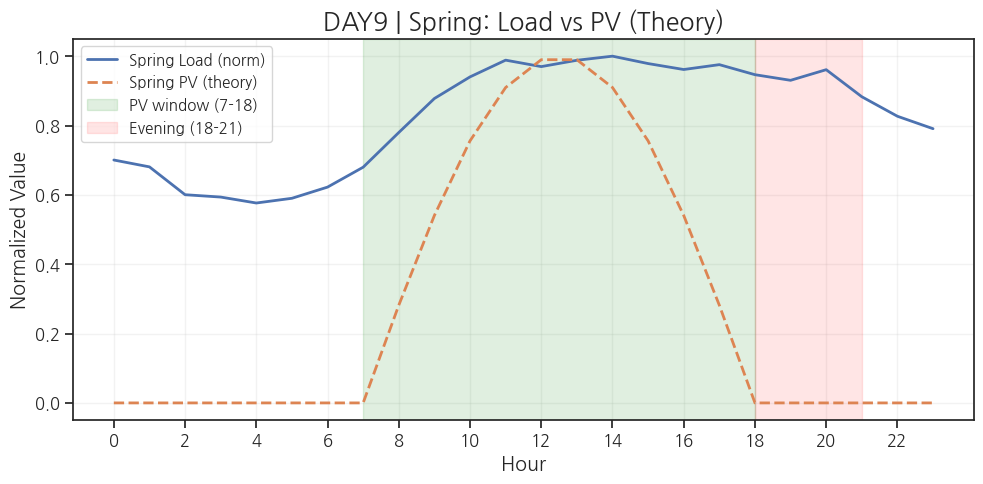

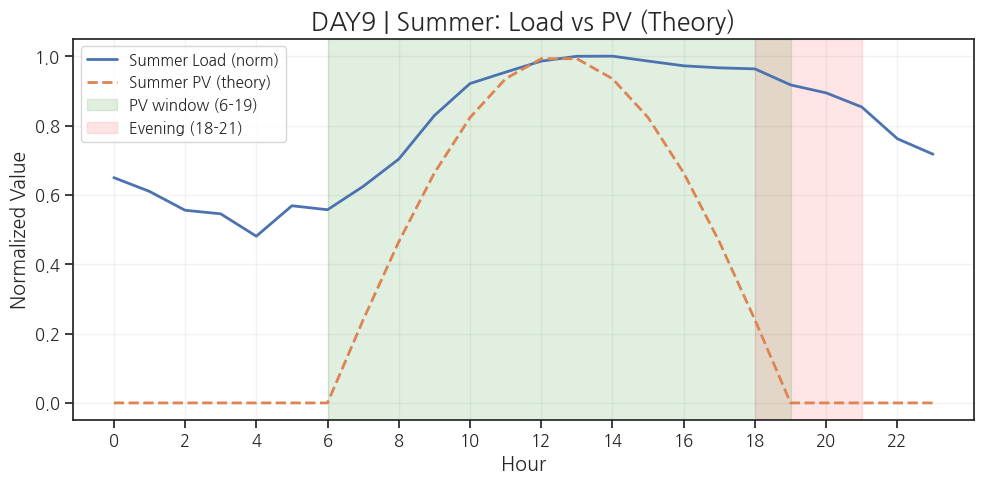

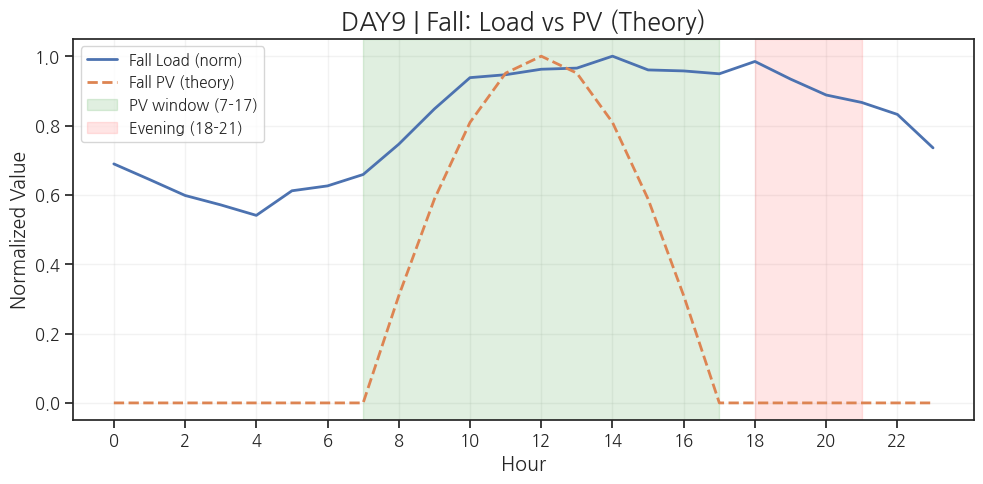

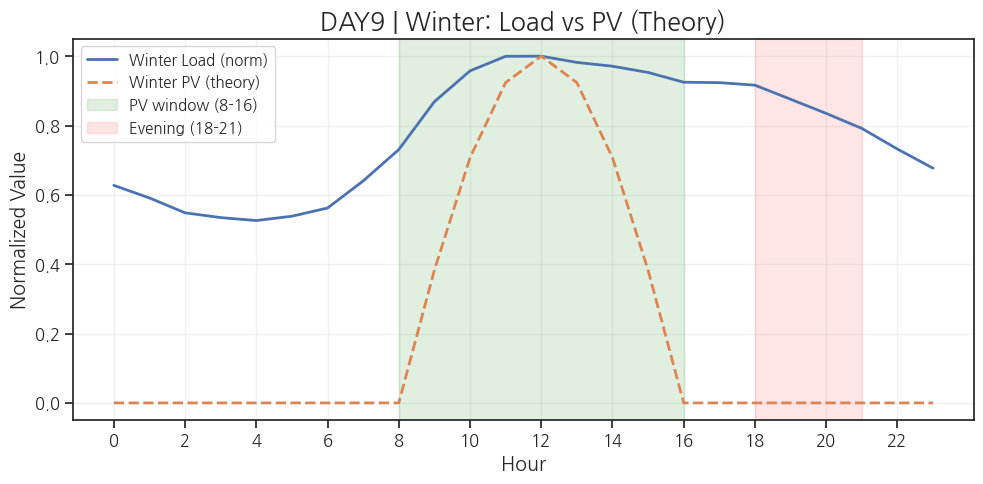

In [7]:
def plot_load_vs_pv(pivot_profile, pv_profile, season, normalize_load=True):
    hours = pivot_profile.index

    load = pivot_profile[season].copy()
    pv = pv_profile.loc[hours, season].copy()

    # 보기 좋게 로드도 0~1 정규화(선택)
    if normalize_load:
        load = load / load.max() if load.max() != 0 else load

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(hours, load, lw=2, label=f"{season} Load (norm)" if normalize_load else f"{season} Load")
    ax.plot(hours, pv, lw=2, linestyle="--", label=f"{season} PV (theory)")

    sr, ss = pv_window_4(season)
    ax.axvspan(sr, ss, alpha=0.12, label=f"PV window ({sr}-{ss})", color="green")
    ax.axvspan(18, 21, alpha=0.10, label="Evening (18-21)",color="red")

    ax.set_title(f"DAY9 | {season}: Load vs PV (Theory)")
    ax.set_xticks(range(0, 24, 1))
    ax.set_xlabel("Hour")
    ax.set_ylabel("Normalized Value" if normalize_load else "Value")
    ax.set_xticks(range(0,24,2))
    ax.grid(alpha=0.25)
    ax.legend()
    plt.tight_layout()
    plt.show()

for s in SEASONS:
    plot_load_vs_pv(pivot_profile, pv_profile, s, normalize_load=True)

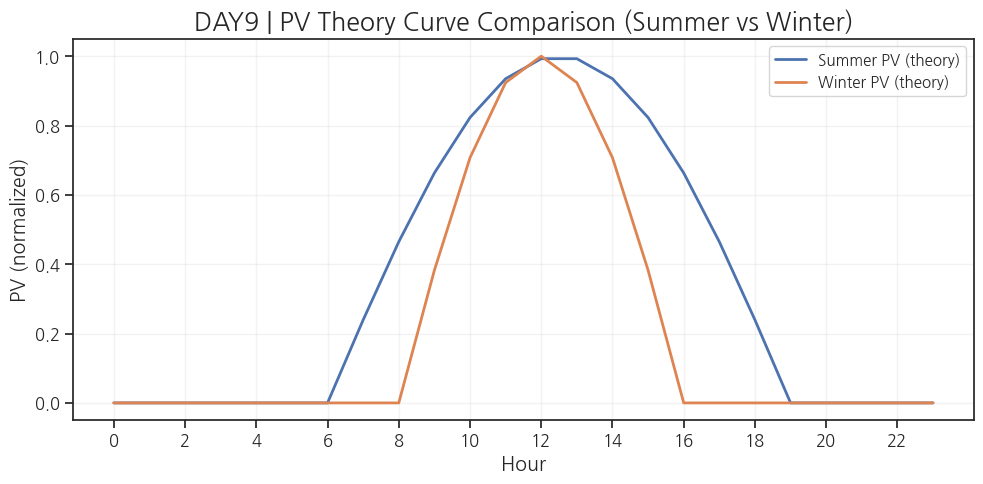

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pv_profile.index, pv_profile["Summer"], lw=2, label="Summer PV (theory)")
ax.plot(pv_profile.index, pv_profile["Winter"], lw=2, label="Winter PV (theory)")
ax.set_title("DAY9 | PV Theory Curve Comparison (Summer vs Winter)")
ax.set_xlabel("Hour")
ax.set_ylabel("PV (normalized)")
ax.set_xticks(range(0,24,2))
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

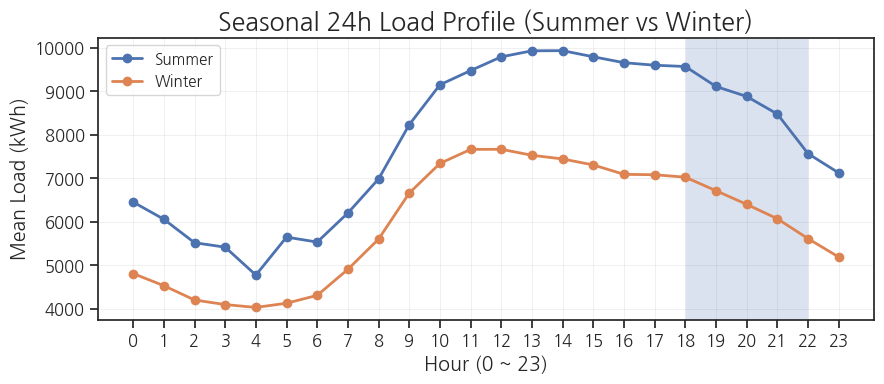

In [9]:
# 3) 그래프
plt.figure(figsize = (9, 4))
plt.plot(pivot_profile.index, pivot_profile["Summer"], marker = "o", linewidth = 2, label = "Summer")
plt.plot(pivot_profile.index, pivot_profile["Winter"], marker = "o", linewidth = 2, label = "Winter")

plt.xticks(range(0, 24, 1))
plt.axvspan(18, 22, alpha=0.2)
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Mean Load (kWh)")
plt.title("Seasonal 24h Load Profile (Summer vs Winter)")
plt.grid(True, linewidth = .5, alpha = .4)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 1) Evening Load 필터 (18–21시)
evening_hours = [18, 19, 20, 21]
evening_df = df9[df9["hour"].isin(evening_hours)].copy()

In [11]:
# 2) 계절별 이브닝 시간대 프로파일 (형태 비교)
evening_profile = (
    evening_df
    .groupby(["season", "hour"])["value"]
    .mean()
    .reset_index())

pivot_evening = (
    evening_profile
    .pivot(index="hour", columns="season", values="value")
    .reindex(evening_hours))

pivot_evening

season,Fall,Spring,Summer,Winter
hour,,,,
18,7186.118624,6007.427249,9566.612323,7023.511775
19,6814.669360,5904.511391,9107.307643,6712.469824
20,6480.093341,6098.987317,8878.561632,6399.433974
21,6323.015956,5603.773419,8474.345639,6068.284600


In [12]:
# 3) 계절별 이브닝 평균값 (요약 지표)
evening_mean = (evening_df .groupby("season")["value"].mean().reindex(SEASONS))

evening_mean


season
Spring    5903.674002
Summer    9006.706809
Fall      6700.974641
Winter    6553.463696
Name: value, dtype: float64

In [13]:
daily_mean = (df9.groupby(["season", "hour"])["value"] .mean() .groupby("season").mean())

evening_ratio = (evening_mean / daily_mean).rename("Evening_to_Daily_Ratio")
evening_ratio

season
Fall      1.132819
Spring    1.125115
Summer    1.144738
Winter    1.096951
Name: Evening_to_Daily_Ratio, dtype: float64

In [14]:
# PV 중심 시간대(이론)
daytime_hours = list(range(10, 16))  # 10–15

# hourly_profile 기준으로 계산 (중요)
daytime_mean = (
    hourly_profile[hourly_profile["hour"].isin(daytime_hours)]
    .groupby("season")["value"]
    .mean()
)

daytime_ratio = daytime_mean / daily_mean

comparison_df = pd.DataFrame({
    "Evening mean (18–21)": evening_mean,
    "Daytime mean (10–15)": daytime_mean,
    "Evening/Daily": evening_ratio,
    "Daytime/Daily": daytime_ratio
})

comparison_df


,Evening mean (18–21),Daytime mean (10–15),Evening/Daily,Daytime/Daily
season,,,,
Fall,6700.974641,7021.158578,1.132819,1.186947
Spring,5903.674002,6204.167187,1.125115,1.182383
Summer,9006.706809,9676.083078,1.144738,1.229814
Winter,6553.463696,7489.932305,1.096951,1.253702


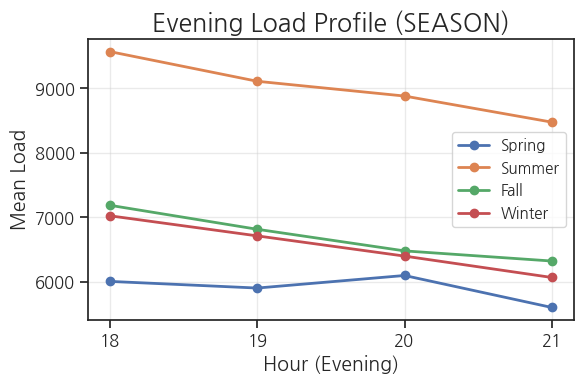

In [15]:
# 이브닝 전용 그래프
plt.figure(figsize=(6,4))
plt.plot(pivot_evening.index, pivot_evening["Spring"], marker="o", linewidth=2, label="Spring")
plt.plot(pivot_evening.index, pivot_evening["Summer"], marker="o", linewidth=2, label="Summer")
plt.plot(pivot_evening.index, pivot_evening["Fall"], marker="o", linewidth=2, label="Fall")
plt.plot(pivot_evening.index, pivot_evening["Winter"], marker="o", linewidth=2, label="Winter")

plt.xticks(evening_hours)
plt.xlabel("Hour (Evening)")
plt.ylabel("Mean Load")
plt.title("Evening Load Profile (SEASON)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


Evening Load는 계절과 관계없이 반복적으로 나타난다.
반면 태양광 발전은 이 시간대에 가용하지 않으며, 계절 변화는 이러한 시간대 불일치를 해소하지 못한다.

In [16]:
def pv_window_4(season):
    if season == "Spring": return (7, 18)
    if season == "Summer": return (6, 19)
    if season == "Fall":   return (7, 17)
    if season == "Winter": return (8, 16)
    raise ValueError("Unknown season")

pv_share_energy = {}
pv_hours_len = {}

for s in SEASONS:
    sr, ss = pv_window_4(s)
    pv_hours = list(range(sr, ss + 1))
    pv_hours_len[s] = len(pv_hours)

    pv_share_energy[s] = pivot_profile.loc[pv_hours, s].sum() / pivot_profile[s].sum()

pv_share_energy = pd.Series(pv_share_energy).rename("PV Window Share (Energy)")
pv_hours_len = pd.Series(pv_hours_len).rename("PV Window Hours (Theory)")

mismatch_index = (evening_share_energy - pv_share_energy).rename("Residual Evening Risk (Evening - PV)")

bridge_table = pd.concat(
    [pv_hours_len, pv_share_energy, evening_share_energy, mismatch_index],
    axis=1
).reindex(SEASONS)

display(bridge_table)

,PV Window Hours (Theory),PV Window Share (Energy),Evening_Energy_Share,Residual Evening Risk (Evening - PV)
Spring,12,0.558720,0.187519,-0.371201
Summer,14,0.650995,0.190790,-0.460205
Fall,11,0.510534,0.188803,-0.321730
Winter,9,0.448368,0.182754,-0.265613


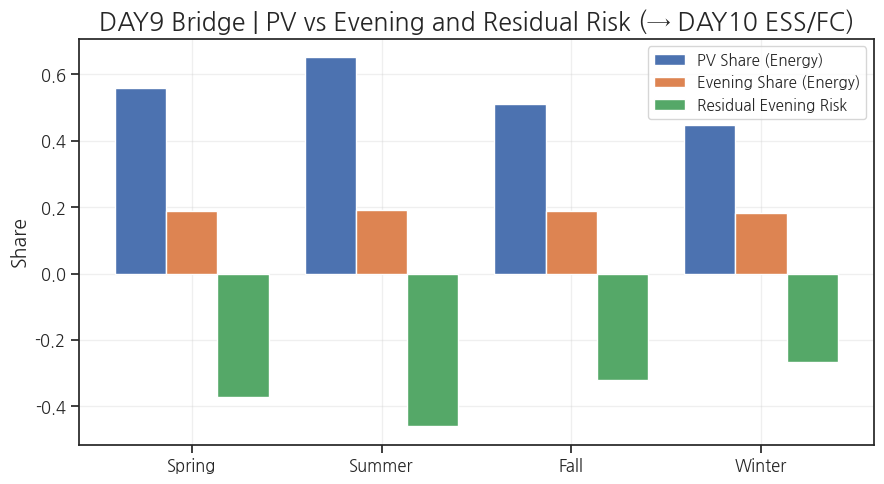

In [17]:
fig, ax = plt.subplots(figsize=(9,5))

x = np.arange(len(SEASONS))
w = 0.27

ax.bar(x - w, bridge_table["PV Window Share (Energy)"].values, width=w, label="PV Share (Energy)")
ax.bar(x,      bridge_table["Evening_Energy_Share"].values, width=w, label="Evening Share (Energy)")
ax.bar(x + w,  bridge_table["Residual Evening Risk (Evening - PV)"].values, width=w, label="Residual Evening Risk")

ax.set_xticks(x)
ax.set_xticklabels(SEASONS)
ax.set_ylabel("Share")
ax.set_title("DAY9 Bridge | PV vs Evening and Residual Risk (→ DAY10 ESS/FC)")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

PV가 가능한 시간 비중이 늘어도, 저녁 집중은 남는다.
남는 차이(Residual Risk)가 바로 ESS/연료전지의 개입 필요 시간대다.

In [18]:
def pv_window(season):
    if season == "Summer":
        return (6, 19)   # 06–19
    if season == "Winter":
        return (8, 16)   # 08–16
    raise ValueError("Unknown season")

s_sr, s_ss = pv_window("Summer")
w_sr, w_ss = pv_window("Winter")

summer_pv_hours = s_ss - s_sr + 1
winter_pv_hours = w_ss - w_sr + 1

print(
    f"PV 가용 시간(이론): "
    f"여름 {summer_pv_hours}h vs 겨울 {winter_pv_hours}h "
    f"(차이 {summer_pv_hours - winter_pv_hours}h)"
)

PV 가용 시간(이론): 여름 14h vs 겨울 9h (차이 5h)


In [19]:
def pv_window_4(season):
    # 이론적 예시(서울 기준 느낌): 봄/가을 중간, 여름 길고, 겨울 짧음
    if season == "Spring":
        return (7, 18)   # 12h
    if season == "Summer":
        return (6, 19)   # 14h
    if season == "Fall":
        return (7, 17)   # 11h
    if season == "Winter":
        return (8, 16)   # 9h
    raise ValueError("Unknown season")

In [20]:
# PV energy share (이론 window 기반)
pv_share_energy = {}
pv_hours_len = {}

for s in SEASONS:
    sr, ss = pv_window_4(s)
    pv_hours = list(range(sr, ss + 1))
    pv_hours_len[s] = len(pv_hours)

    # pivot_profile에서 해당 시간대 합 / 하루 합
    pv_share_energy[s] = pivot_profile.loc[pv_hours, s].sum() / pivot_profile[s].sum()

pv_share_energy = pd.Series(pv_share_energy).rename("PV Window Share (Energy)")
pv_hours_len = pd.Series(pv_hours_len).rename("PV Window Hours (Theory)")

# “저녁 리스크”를 한 줄로: Evening share - PV share
# (PV 시간대에 쓸 수 있는 비중보다, 저녁에 더 많이 몰리면 → 남는 리스크)
mismatch_index = (evening_share_energy - pv_share_energy).rename("Mismatch Index (Evening - PV)")

bridge_table = pd.concat([pv_hours_len, pv_share_energy, evening_share_energy, mismatch_index], axis=1).reindex(SEASONS)
bridge_table

,PV Window Hours (Theory),PV Window Share (Energy),Evening_Energy_Share,Mismatch Index (Evening - PV)
Spring,12,0.558720,0.187519,-0.371201
Summer,14,0.650995,0.190790,-0.460205
Fall,11,0.510534,0.188803,-0.321730
Winter,9,0.448368,0.182754,-0.265613


In [21]:
# =========================
# DAY 9 Conclusion (Seasonal)
# =========================

evening_mean = (df9[df9["hour"].between(18, 21)].groupby("season")["value"].mean().reindex(["Summer", "Winter"]))

daily_mean = (df9.groupby("season")["value"].mean().reindex(["Summer", "Winter"]))

evening_share = (evening_mean / daily_mean)

summary = pd.DataFrame({
    "Evening mean (18-21)": evening_mean,
    "Daily mean (0-23)": daily_mean,
    "Evening share (Evening/Daily)": evening_share})

display(summary)

delta = evening_mean["Winter"] - evening_mean["Summer"]
ratio = evening_mean["Winter"] / evening_mean["Summer"]

print("[DAY 9 핵심 요약]")
print(f"- 이브닝 시간대(18–21시) 평균 부하는 계절에 따라 차이를 보이며, 계절 효과가 관측된다.")
print(f"- 겨울/여름 이브닝 부하 비율: {ratio:.2f}배")
print()
print("최종 메시지:")
print("계절적 요인은 태양광의 상대적 기여 가능성에 영향을 주지만, 이브닝 시간대의 구조적 전력 부담 자체를 해소하지는 못한다.")


,Evening mean (18-21),Daily mean (0-23),Evening share (Evening/Daily)
season,,,
Summer,9006.706809,7868.642232,1.144633
Winter,6553.463696,5974.580477,1.096891


[DAY 9 핵심 요약]
- 이브닝 시간대(18–21시) 평균 부하는 계절에 따라 차이를 보이며, 계절 효과가 관측된다.
- 겨울/여름 이브닝 부하 비율: 0.73배

최종 메시지:
계절적 요인은 태양광의 상대적 기여 가능성에 영향을 주지만, 이브닝 시간대의 구조적 전력 부담 자체를 해소하지는 못한다.


계절에 따라 전력 수요 수준과 태양광 가용 시간은 달라지지만, 저녁(18–21) 수요 집중은 모든 계절에서 유지된다.
따라서 문제의 핵심은 계절이 아니라 ‘시간대 불일치(Time-of-Day mismatch)’ 구조에 있다.

In [22]:
OUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = PROJECT_ROOT / "figures"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

pivot_profile.to_csv(OUT_DIR / "DAY9_seasonal_24h_profile.csv", encoding="utf-8-sig")
# pivot_evening은 네가 따로 만들면 저장, 아니면 생략 가능
# pivot_evening.to_csv(OUT_DIR / "DAY9_seasonal_evening_profile.csv", encoding="utf-8-sig")

summary.to_csv(OUT_DIR / "DAY9_evening_summary.csv", encoding="utf-8-sig")
bridge_table.to_csv(OUT_DIR / "DAY9_bridge_table_mismatch.csv", encoding="utf-8-sig")

print("DAY9 outputs saved.")

DAY9 outputs saved.
